## Build an ensemble using algorithms and distances, finish to see if it uncovers the lack of structure

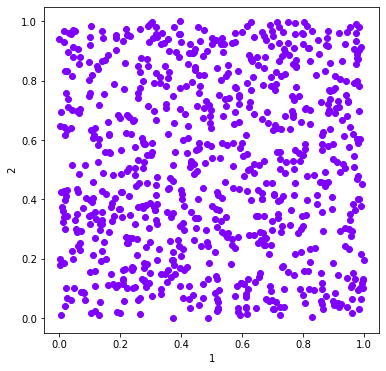

In [1]:
import numpy as np
import pandas as pd 
import openensembles as oe
import matplotlib.pyplot as plt


n_samples = 800
np.random.seed(0) #this helps to establish the same dataset and functionality, but is not required

no_structure = np.random.rand(n_samples, 2), None
X,y = no_structure
df = pd.DataFrame(X)
d = oe.data(df, [1,2])


plt_data = d.plot_data('parent')
   

### Create an ensemble


In [2]:
c  = oe.cluster(d) #instantiate an object so we can get all available algorithms
a = c.algorithms_available()
paramsC = c.clustering_algorithm_parameters() #here we will rely on walking through 
    
# remove DBSCAN -- this does very well on unstructured data, we want to ask if we can use poorly performing algorithms 
# to identify if there isn't structure.
algorithmsToRemove = ['DBSCAN']
for algToRemove in algorithmsToRemove:
    del a[algToRemove]

takesLinkages = paramsC['linkage']
takesDistances = paramsC['distance']
takesK = paramsC['K']



In [3]:
#setup the parameters of clustering here, algorithms are set by algorithms_available
K = range(3, 20, 2)
linkages = ['average', 'complete', 'ward'] 
distances = ['euclidean', 'l1', 'l2']


In [4]:
# Create an ensemble: sweep K, distance metrics
c = oe.cluster(d)
for data_source in d.D.keys(): #if there were transformations in d.D
    for algorithm in list(a.keys()): #linkage is only for agglomerative, which also accepts K and distances, so handle that here
        if algorithm in takesK:
            for k in K:
                if algorithm in takesDistances:
                    if algorithm in takesLinkages:
                        for linkage in linkages:
                            if linkage == 'ward':
                                out_name = '_'.join([data_source, algorithm, linkage, str(k)])
                                c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, linkage=linkage)
                            else:
                                for dist in distances:
                                    out_name = '_'.join([data_source, algorithm, dist, linkage, str(k)])
                                    c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, linkage=linkage, distance=dist)



                    else:
                        for dist in distances:
                            out_name = '_'.join([data_source, algorithm, dist, str(k)])
                            c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, distance=dist)
                else:
                    out_name = '_'.join([data_source, algorithm, str(k)])
                    c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True)


        else: # does not take K
            if algorithm in takesDistances:
                    for dist in distances:
                        out_name = '_'.join([data_source, algorithm, dist])
                        c.cluster(data_source, algorithm, out_name, Require_Unique= True, distance=dist)
            else:
                out_name = '_'.join([data_source, algorithm])
                c.cluster(data_source, algorithm, out_name, Require_Unique= True)

        

### Plot example solutions from the ensemble 

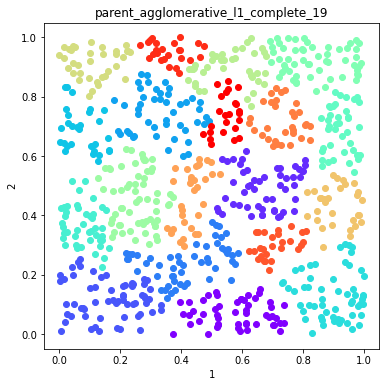

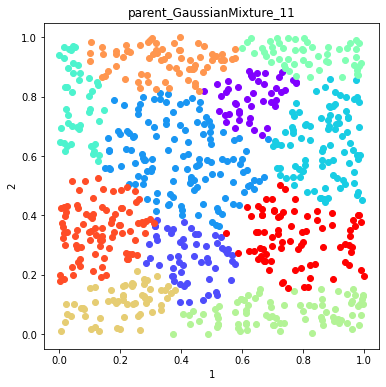

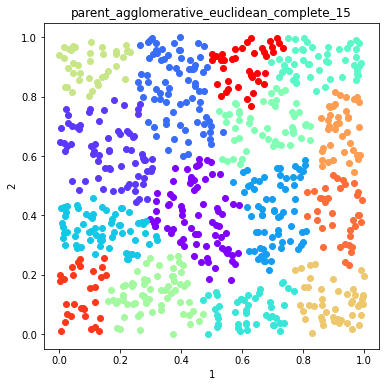

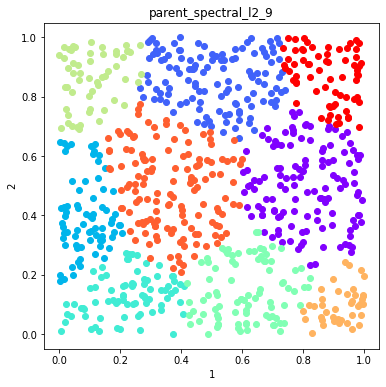

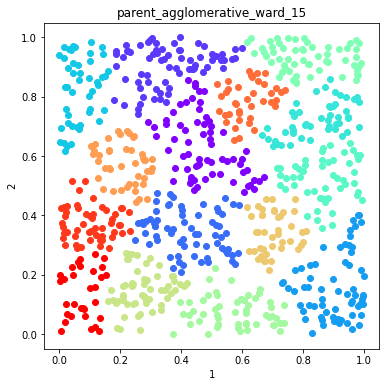

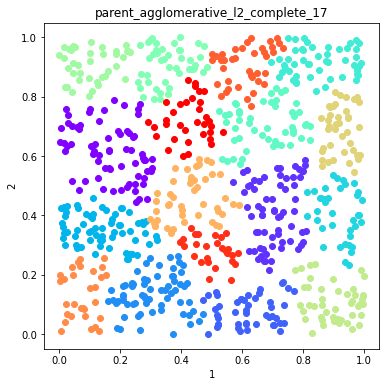

In [5]:
#plot some random number of solutions
names = c.labels.keys()
figs =[]
fig = 0

numSolutions = 6
#namesToSelect = random.sample(names, numSolutions)
namesToSelect = np.random.choice(list(names), numSolutions, replace=False)
for name in namesToSelect:
    d.plot_data('parent', fig_num=fig, class_labels=c.labels[name], title=name)
    fig+=1
        

### Finish the ensemble using Majority Vote and Graph Closure 

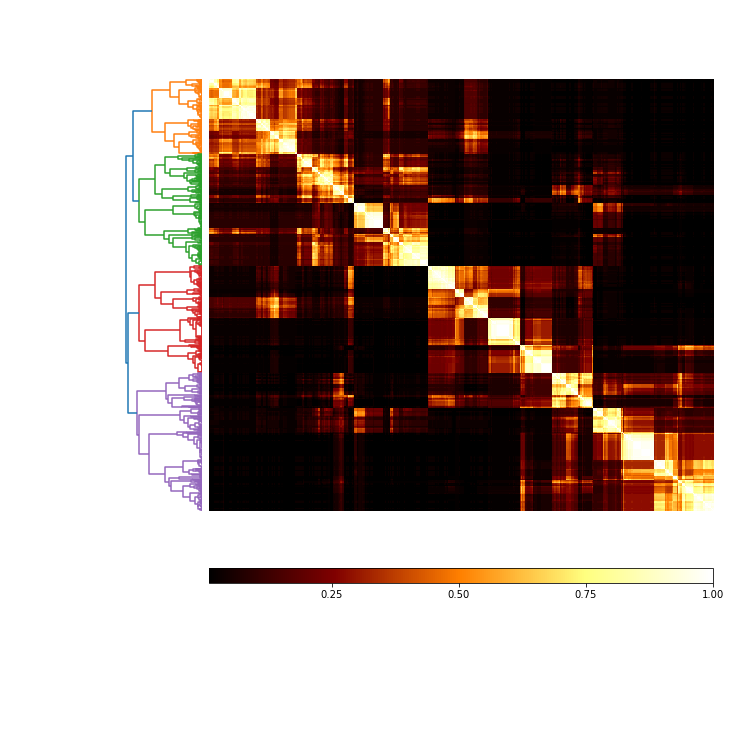

In [6]:
#View the ensembles
coMat = c.co_occurrence_matrix()

fig = coMat.plot(add_labels=False)


#### Graph Closure and Majority Vote Finishing

In [7]:
# Explore effects of threshold on graph closure
thresholds = [0.5, 0.6, 0.7]
fig = 0
c_graph_dict = {}
c_majority_vote_dict = {}
for threshold in thresholds:
    c_graph = c.finish_graph_closure(threshold=threshold)
    c_graph_dict[str(threshold)] = c_graph
    c_majority_vote = c.finish_majority_vote(threshold=threshold)
    c_majority_vote_dict[str(threshold)] = c_majority_vote

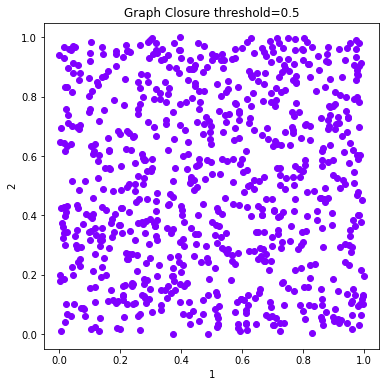

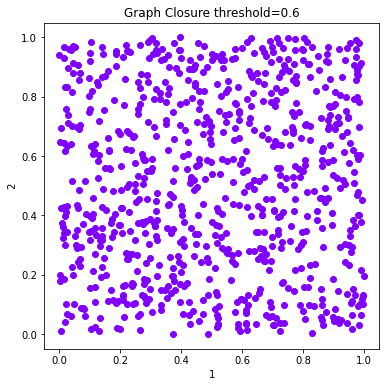

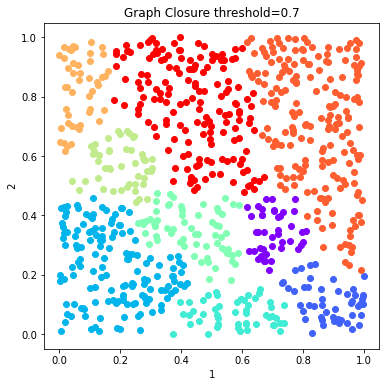

In [8]:
# Plot the solutions of Graph Closure
fig = 0
for threshold in c_graph_dict:
    labels = c_graph_dict[threshold].labels['graph_closure']
    d.plot_data('parent', fig_num = fig, class_labels=labels, title='Graph Closure threshold=%s'%(threshold))
    fig+=1


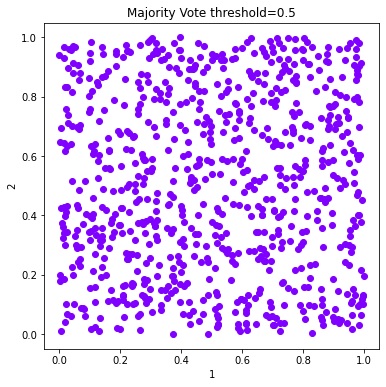

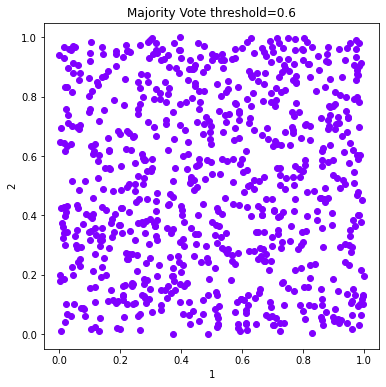

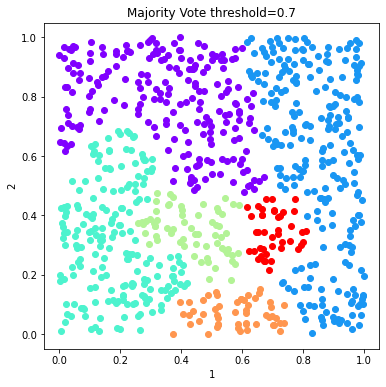

In [9]:
# Plot the solutions of Majority Vote
fig = 0
figs =[]
for threshold in c_majority_vote_dict:
    labels = c_majority_vote_dict[threshold].labels['majority_vote']
    d.plot_data('parent', fig_num = fig, class_labels=labels, title='Majority Vote threshold=%s'%(threshold))
    fig+=1

### Use mutual information to compare solutions


In [10]:
mi_adjusted = c.MI(MI_type='adjusted')

In [11]:
mi_adjusted.matrix

,parent_AffinityPropagation_euclidean,parent_AffinityPropagation_l1,parent_AffinityPropagation_l2,parent_Birch_3,parent_Birch_5,parent_Birch_7,parent_Birch_9,parent_Birch_11,parent_Birch_13,parent_Birch_15,...,parent_spectral_l2_13,parent_spectral_euclidean_15,parent_spectral_l1_15,parent_spectral_l2_15,parent_spectral_euclidean_17,parent_spectral_l1_17,parent_spectral_l2_17,parent_spectral_euclidean_19,parent_spectral_l1_19,parent_spectral_l2_19
parent_AffinityPropagation_euclidean,1.0,0.969941,1.0,0.53533,0.588711,0.598626,0.565102,0.539072,0.536421,0.51596,...,0.552151,0.537204,0.520182,0.534409,0.509064,0.511144,0.512794,0.491146,0.481378,0.494583
parent_AffinityPropagation_l1,0.969941,1.0,0.969941,0.535193,0.589659,0.597436,0.563175,0.537255,0.535212,0.514802,...,0.553737,0.544558,0.518381,0.541775,0.509783,0.513119,0.513668,0.49179,0.481861,0.495228
parent_AffinityPropagation_l2,1.0,0.969941,1.0,0.53533,0.588711,0.598626,0.565102,0.539072,0.536421,0.51596,...,0.552151,0.537204,0.520182,0.534409,0.509064,0.511144,0.512794,0.491146,0.481378,0.494583
parent_Birch_3,0.53533,0.535193,0.53533,1.0,0.797995,0.710356,0.652631,0.613799,0.584213,0.559569,...,0.418875,0.449921,0.426089,0.451691,0.457276,0.428064,0.448247,0.425964,0.430374,0.41837
parent_Birch_5,0.588711,0.589659,0.588711,0.797995,1.0,0.90691,0.843608,0.800095,0.766409,0.737979,...,0.541362,0.592401,0.559478,0.592515,0.566349,0.541955,0.574147,0.551822,0.535815,0.551853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
parent_spectral_l1_17,0.511144,0.513119,0.511144,0.428064,0.541955,0.612765,0.657557,0.66832,0.674726,0.705532,...,0.75896,0.775011,0.793162,0.774445,0.761963,1.0,0.776813,0.752915,0.748487,0.75456
parent_spectral_l2_17,0.512794,0.513668,0.512794,0.448247,0.574147,0.640012,0.67637,0.68908,0.690357,0.712109,...,0.752843,0.821791,0.79629,0.820391,0.902564,0.776813,1.0,0.793866,0.724944,0.810557
parent_spectral_euclidean_19,0.491146,0.49179,0.491146,0.425964,0.551822,0.622116,0.659149,0.666747,0.671274,0.688036,...,0.719309,0.769043,0.741931,0.770196,0.798569,0.752915,0.793866,1.0,0.76557,0.935674
parent_spectral_l1_19,0.481378,0.481861,0.481378,0.430374,0.535815,0.596919,0.640646,0.653699,0.659841,0.676507,...,0.69741,0.715167,0.6999,0.716911,0.75862,0.748487,0.724944,0.76557,1.0,0.762221


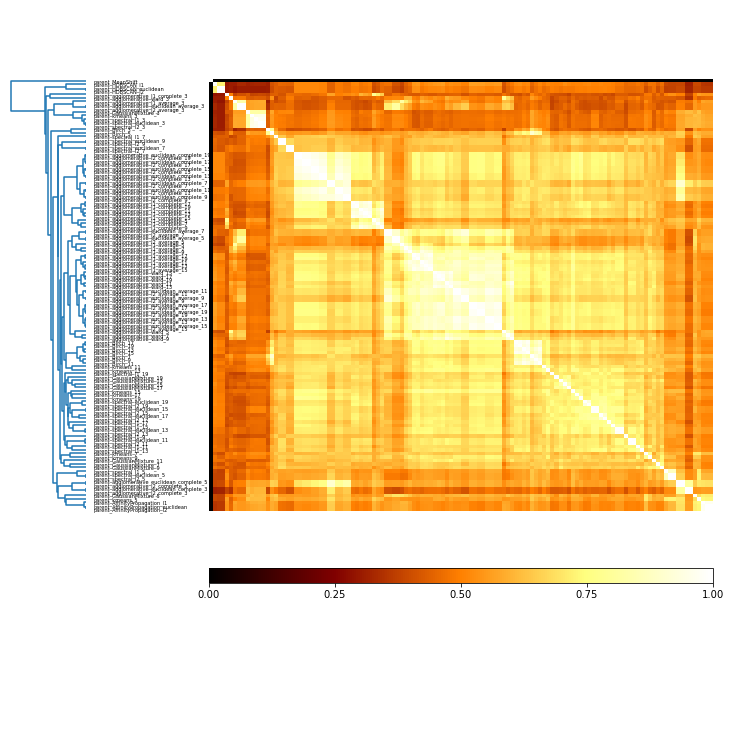

In [12]:
mi_plot = mi_adjusted.plot()

In [13]:
#plot MI with type of algorithm as label
label_vec = []
for index, row in mi_adjusted.matrix.iterrows():
    name = c.algorithms[index]
    label_vec.append(name)

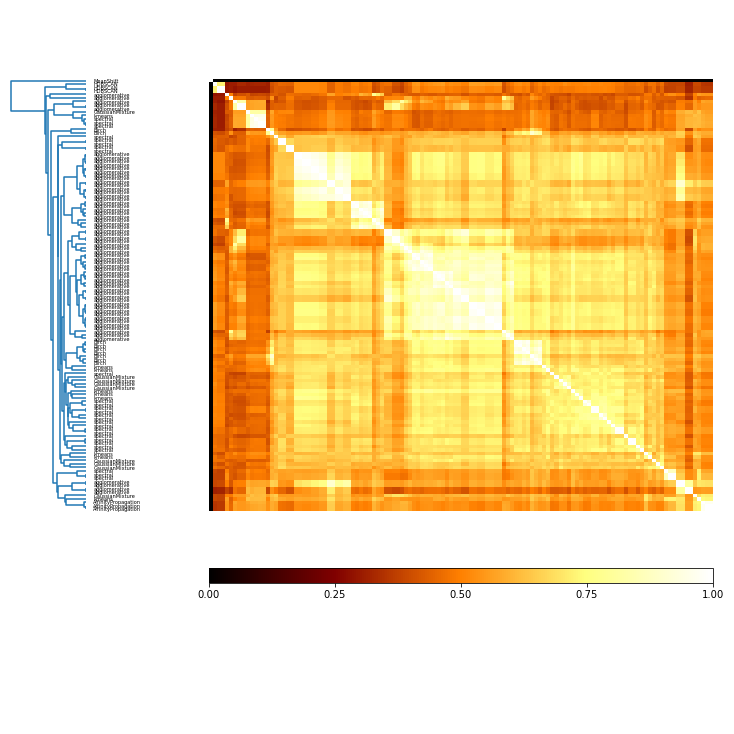

In [14]:
mi_plot = mi_adjusted.plot(threshold= 0, label_vec=label_vec)